In [21]:
import glob
import os
import pathlib

import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
from keras import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    MaxPooling2D,
    experimental,
)

In [22]:
data_dir_train = pathlib.Path("./data/Train")
data_dir_test = pathlib.Path("./data/Test")

In [23]:
image_train = list(data_dir_train.glob("*/*.jpg"))
print(len(image_train))
image_test = list(data_dir_test.glob("*/*.jpg"))
print(len(image_test))

1393
118


In [24]:
batch_size = 32
img_height = 180
img_width = 180

In [25]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    subset="training",
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 1393 files belonging to 9 classes.
Using 1115 files for training.


In [26]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    subset="validation",
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 1393 files belonging to 9 classes.
Using 278 files for validation.


In [27]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


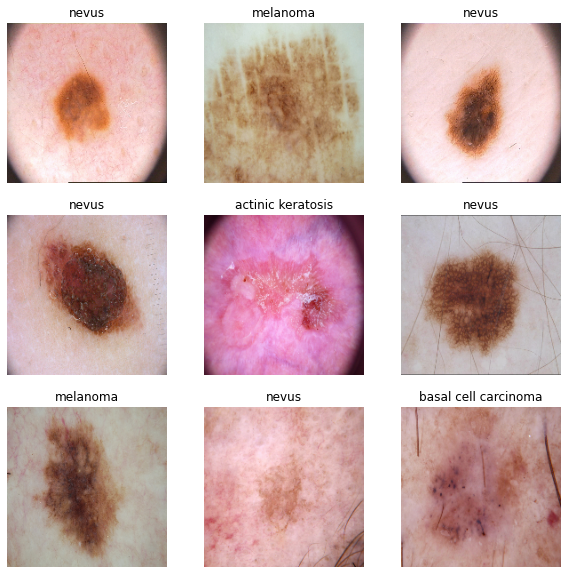

In [28]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [29]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [30]:
num_classes = len(class_names)

model = Sequential(
    [
        experimental.preprocessing.Rescaling(
            1.0 / 255, input_shape=(img_height, img_width, 3)
        ),
        Conv2D(16, 3, padding="same", activation="relu"),
        MaxPooling2D(),
        Conv2D(32, 3, padding="same", activation="relu"),
        MaxPooling2D(),
        Conv2D(64, 3, padding="same", activation="relu"),
        MaxPooling2D(),
        Flatten(),
        Dense(128, activation="relu"),
        Dense(num_classes),
    ]
)

In [31]:
model.compile(
    optimizer="adam",
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [33]:
model.summary(expand_nested=True, show_trainable=True)

Model: "sequential"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 rescaling (Rescaling)       (None, 180, 180, 3)       0         Y          
                                                                            
 conv2d (Conv2D)             (None, 180, 180, 16)      448       Y          
                                                                            
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         Y          
 )                                                                          
                                                                            
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      Y          
                                                                            
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         Y          
 2D)                                                    

In [34]:
epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/20
35/35 [==============================] - 35s 828ms/step - loss: 1.5451 - accuracy: 0.3713 - val_loss: 1.4188 - val_accuracy: 0.5288
Epoch 2/20
35/35 [==============================] - 28s 800ms/step - loss: 1.1650 - accuracy: 0.5632 - val_loss: 1.0988 - val_accuracy: 0.6043
Epoch 3/20
35/35 [==============================] - 27s 771ms/step - loss: 1.0535 - accuracy: 0.5964 - val_loss: 1.1973 - val_accuracy: 0.5576
Epoch 4/20
35/35 [==============================] - 27s 771ms/step - loss: 1.0449 - accuracy: 0.5883 - val_loss: 1.0586 - val_accuracy: 0.5935
Epoch 5/20
35/35 [==============================] - 28s 793ms/step - loss: 0.9795 - accuracy: 0.6179 - val_loss: 1.0236 - val_accuracy: 0.6223
Epoch 6/20
35/35 [==============================] - 27s 786ms/step - loss: 0.9189 - accuracy: 0.6404 - val_loss: 1.0288 - val_accuracy: 0.6079
Epoch 7/20
35/35 [==============================] - 28s 789ms/step - loss: 0.8808 - accuracy: 0.6664 - val_loss: 1.0031 - val_accuracy: 0.6223

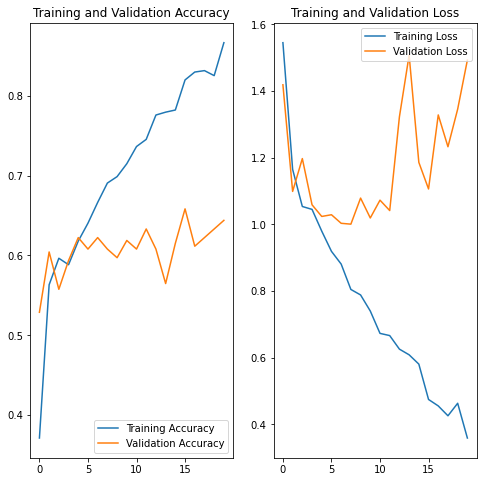

In [35]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

In [36]:
data_augmentation = keras.Sequential(
    [
        experimental.preprocessing.RandomFlip(
            "horizontal", input_shape=(img_height, img_width, 3)
        ),
        experimental.preprocessing.RandomRotation(0.1),
        experimental.preprocessing.RandomZoom(0.1),
    ]
)

In [37]:
model = Sequential(
    [
        data_augmentation,
        experimental.preprocessing.Rescaling(1.0 / 255),
        Conv2D(16, 3, padding="same", activation="relu"),
        MaxPooling2D(),
        Conv2D(32, 3, padding="same", activation="relu"),
        MaxPooling2D(),
        Conv2D(64, 3, padding="same", activation="relu"),
        MaxPooling2D(),
        Dropout(0.2),
        Flatten(),
        Dense(128, activation="relu"),
        Dense(num_classes),
    ]
)

In [38]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy", "mse"],
)

In [39]:
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/20
35/35 [==============================] - 32s 888ms/step - loss: 1.6476 - accuracy: 0.3525 - mse: 11.2495 - val_loss: 1.3707 - val_accuracy: 0.5108 - val_mse: 9.4930
Epoch 2/20
35/35 [==============================] - 31s 896ms/step - loss: 1.2786 - accuracy: 0.5112 - mse: 13.0556 - val_loss: 1.1547 - val_accuracy: 0.5683 - val_mse: 12.0537
Epoch 3/20
35/35 [==============================] - 28s 805ms/step - loss: 1.0992 - accuracy: 0.5740 - mse: 15.6974 - val_loss: 1.3767 - val_accuracy: 0.4676 - val_mse: 13.6833
Epoch 4/20
35/35 [==============================] - 30s 852ms/step - loss: 1.1498 - accuracy: 0.5561 - mse: 14.7285 - val_loss: 1.1202 - val_accuracy: 0.5863 - val_mse: 14.3492
Epoch 5/20
35/35 [==============================] - 28s 814ms/step - loss: 1.1089 - accuracy: 0.5686 - mse: 17.3701 - val_loss: 1.0371 - val_accuracy: 0.6115 - val_mse: 17.6034
Epoch 6/20
35/35 [==============================] - 32s 924ms/step - loss: 1.0350 - accuracy: 0.5892 - mse: 20.7058 

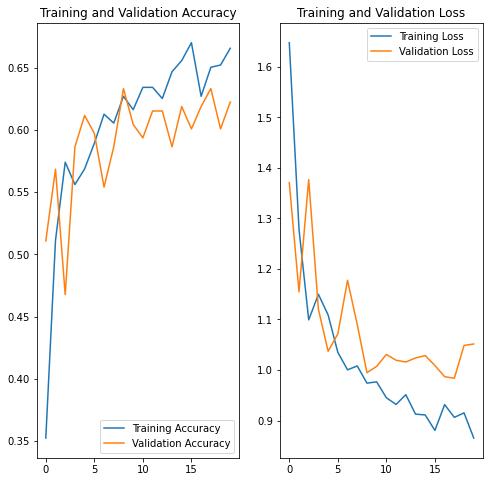

In [40]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

In [45]:
# model accuracy
accuracy = model.evaluate(val_ds)
print(f"Accuracy: {accuracy[1]*100:.2f}%")

9/9 [==============================] - 1s 131ms/step - loss: 1.0515 - accuracy: 0.6223 - mse: 54.3896
Accuracy: 62.23%


In [46]:
model.save("model.h5")